In [ ]:
!wget -O credit_scoring.csv https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv

--2024-06-13 12:57:19--  https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 16.12.18.10, 52.95.154.98
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|16.12.18.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46681024 (45M) [text/csv]
Saving to: ‘credit_scoring.csv’

credit_scoring.csv  100%[===================>]  44.52M  8.92MB/s    in 5.5s    

2024-06-13 12:57:26 (8.12 MB/s) - ‘credit_scoring.csv’ saved [46681024/46681024]



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14, 10]
plt.style.use("seaborn-v0_8-darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



def chi2(X, y_target):
    """
    Calcolo del test di indipendenza tra variabile categoriche.
    X, y_target: rispettivamente variabile indipendente, variabile dipendente.
    """

    data = pd.crosstab(y_target, X)

    chi2, p, dof, expected = chi2_contingency(data)

    print(f"Chi2: {chi2:.2f}")
    print(f"P-value: {p:.2f}")
    print(f"Gradi di Libertà: {dof}")

    if p < 0.05:
        print("Le variabili sono dipendenti.")
    else:
        print("Le variabili sono indipendenti.")


def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], normalize=False,  title="Confusion Matrix"):
    """
    Grafico che rappresenta i veri e falsi positivi e i veri e falsi negativi, punteggi del modello.
    """

    cm = confusion_matrix(y_true, y_pred, normalize="true" if normalize else None)

    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted "+labels[0],"Predicted "+labels[1]])

    sns.heatmap(df_cm, annot=True, fmt=".2f" if normalize else "d")
    plt.title(title)


def evaluate(model, X_train, X_test, y_train, y_test):
  """
  Valutazione per la bontà del modello e overfitting.
  """

  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  print("TRAIN REPORT")
  print(classification_report(y_train, y_pred_train))
  print("TEST REPORT")
  print(classification_report(y_test, y_pred_test))
  print("-----------------------------------------------------")

In [ ]:
dataset_original = pd.read_csv("credit_scoring.csv")

In [ ]:
dataset_original.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


**Panoramica dei dati.**

In [ ]:
dataset = dataset_original.copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

**Preprocessing dei dati.**

Eliminazione della features "ID" perché non veicola nessuna informazione.

In [ ]:
dataset = dataset.drop(["ID"], axis=1)

Trasformazione delle features categoriche utilizzando il metodo map().

In [ ]:
dataset["CODE_GENDER"].value_counts()

CODE_GENDER
F    227916
M    110511
Name: count, dtype: int64

In [ ]:
gender_dict = {"M": 1, "F": 0}
dataset["CODE_GENDER"] = dataset["CODE_GENDER"].map(gender_dict)

dataset["CODE_GENDER"].value_counts()

CODE_GENDER
0    227916
1    110511
Name: count, dtype: int64

In [ ]:
dataset["FLAG_OWN_CAR"].value_counts()

FLAG_OWN_CAR
N    213196
Y    125231
Name: count, dtype: int64

In [ ]:
yes_no_dict = {"Y": 1, "N": 0}

dataset["FLAG_OWN_CAR"] = dataset["FLAG_OWN_CAR"].map(yes_no_dict)

dataset["FLAG_OWN_CAR"].value_counts()

FLAG_OWN_CAR
0    213196
1    125231
Name: count, dtype: int64

In [ ]:
dataset["FLAG_OWN_REALTY"].value_counts()

FLAG_OWN_REALTY
Y    231307
N    107120
Name: count, dtype: int64

In [ ]:
dataset["FLAG_OWN_REALTY"] = dataset["FLAG_OWN_REALTY"].map(yes_no_dict)

dataset["FLAG_OWN_REALTY"].value_counts()

FLAG_OWN_REALTY
1    231307
0    107120
Name: count, dtype: int64

Trasformazione della feature "NAME_INCOME_TYPE" rappresentata da una variabile dicotomica con più di due categorie che successivamente verrà passata al OneHotEncoder per evitare che il modello apprenda una ordinabilità inesistente.

Il valore "Student" non viene tenuto in considerazione e verrà eliminato perché la creazione di una fearure composta quasi totalmente da zeri (0) risulta poco informativa e può appesantire il modello inutilmente.

In [ ]:
dataset["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 174366
Commercial associate     78090
Pensioner                57841
State servant            28113
Student                     17
Name: count, dtype: int64

In [ ]:
name_income_dict = {"Working": 0, "Commercial associate": 1, "Pensioner": 2, "State servant": 3}

dataset["NAME_INCOME_TYPE"] = dataset["NAME_INCOME_TYPE"].map(name_income_dict)

dataset["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
0.0    174366
1.0     78090
2.0     57841
3.0     28113
Name: count, dtype: int64

Trasformazione della feature "NAME_EDUCATION_TYPE" rappresentata da una variabile ordinabile.

La stringa "Secondary / se" si presume essere un erorre di battitura e quindi sarebbe dovuta essere equivalente a "Secondary / secondary special", in questo senso viene corretto l'errore.

In [ ]:
dataset["NAME_EDUCATION_TYPE"].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    232568
Higher education                  91062
Incomplete higher                 11387
Lower secondary                    3177
Academic degree                     232
Secondary / se                        1
Name: count, dtype: int64

In [ ]:
education_dict = {"Lower secondary": 0, "Secondary / secondary special": 1, "Secondary / se": 1, "Incomplete higher": 2, "Higher education": 3, "Academic degree": 4}

dataset["NAME_EDUCATION_TYPE"] = dataset["NAME_EDUCATION_TYPE"].map(education_dict)

dataset["NAME_EDUCATION_TYPE"].value_counts()

NAME_EDUCATION_TYPE
1    232569
3     91062
2     11387
0      3177
4       232
Name: count, dtype: int64

Trasformazione della feature "NAME_FAMILY_STATUS" rappresentata da una variabile dicotomica con più di due categorie che successivamente verrà passata al OneHotEncoder per evitare che il modello apprenda una ordinabilità inesistente.

Il valore del dato stringa "Married" e "Civil marriage" vengono accorpate per ragioni di similarità al fine di evitare di dover generare troppe features con il OneHotEncoder.

In [ ]:
dataset["NAME_FAMILY_STATUS"].value_counts()

NAME_FAMILY_STATUS
Married                 231494
Single / not married     42509
Civil marriage           28516
Separated                20809
Widow                    15098
Name: count, dtype: int64

In [ ]:
family_dict = {"Married": 4, "Civil marriage": 4, "Single / not married": 5, "Separated": 6, "Widow": 7}

dataset["NAME_FAMILY_STATUS"] = dataset["NAME_FAMILY_STATUS"].map(family_dict)

dataset["NAME_FAMILY_STATUS"].value_counts()

NAME_FAMILY_STATUS
4.0    260010
5.0     42509
6.0     20809
7.0     15098
Name: count, dtype: int64

Trasformazione della feature "NAME_HOUSING_TYPE" rappresentata da una variabile dicotomica con più di due categorie che verranno accorpate per ragioni di similarità fino alla rduzione di due categorie.

In [ ]:
dataset["NAME_HOUSING_TYPE"].value_counts()

NAME_HOUSING_TYPE
House / apartment      304410
With parents            14625
Municipal apartment     10819
Rented apartment         4442
Office apartment         2968
Co-op apartment          1162
Name: count, dtype: int64

In [ ]:
house_dict = {"House / apartment": 1, "Municipal apartment": 1, "Rented apartment": 1, "Office apartment": 1, "Co-op apartment": 1, "With parents": 0}

dataset["NAME_HOUSING_TYPE"] = dataset["NAME_HOUSING_TYPE"].map(house_dict)

dataset["NAME_HOUSING_TYPE"].value_counts()

NAME_HOUSING_TYPE
1.0    323801
0.0     14625
Name: count, dtype: int64

Trasformazione della feature "OCCUPATION_TYPE" rappresentata da una variabile dicotomica con più di due categorie che successivamente verrà passata al OneHotEncoder per evitare che il modello apprenda una ordinabilità inesistente. La grande quantità di features che si genererebbe renderbbe il modello instabile per il loro basso valore informativo essendo principalmente valorizzate con zeri (0). Si procede con la realizzazione di categorie accorpate.

In [ ]:
dataset["OCCUPATION_TYPE"].value_counts()

OCCUPATION_TYPE
Laborers                 60146
Core staff               33527
Sales staff              31652
Managers                 27384
Drivers                  20020
High skill tech staff    13399
Accountants              12281
Medicine staff           10438
Cooking staff             6248
Security staff            6218
Cleaning staff            4594
Private service staff     2787
Low-skill Laborers        1714
Secretaries               1577
Waiters/barmen staff      1245
Realty agents              852
HR staff                   567
IT staff                   436
Name: count, dtype: int64

L'eliminazione di così tante osservazioni causerebbe una perdita troppo importante di dati, quindi la mancanza di valori viene gestita attribuendoli una categoria assestante.

In [ ]:
dataset["OCCUPATION_TYPE"].isna().sum()

103342

In [ ]:
dataset["OCCUPATION_TYPE"] = dataset["OCCUPATION_TYPE"].fillna("Other")

Attraverso una funzione lambda si valorizzano con "Staff" tutti i valori che non sono nelle categorie d'intresse.

In [ ]:
dataset["OCCUPATION_TYPE"] = dataset["OCCUPATION_TYPE"].apply(lambda x: x if x in ["Laborers", "Low-skill Laborers", "Other"] else "Staff")

In [ ]:
dataset["OCCUPATION_TYPE"].value_counts()

OCCUPATION_TYPE
Staff                 173225
Other                 103342
Laborers               60146
Low-skill Laborers      1714
Name: count, dtype: int64

Utilizzo del metodo map() per restituire le categorie finali da passare al OneHotEncoder.

In [ ]:
occupation_dict = {"Staff": 8, "Laborers": 9, "Low-skill Laborers": 9, "Other": 10}

dataset["OCCUPATION_TYPE"] = dataset["OCCUPATION_TYPE"].map(occupation_dict)

dataset["OCCUPATION_TYPE"].value_counts()

OCCUPATION_TYPE
8     173225
10    103342
9      61860
Name: count, dtype: int64

In [ ]:
dataset.isna().sum()

CODE_GENDER             0
FLAG_OWN_CAR            0
FLAG_OWN_REALTY         0
CNT_CHILDREN            0
AMT_INCOME_TOTAL        0
NAME_INCOME_TYPE       17
NAME_EDUCATION_TYPE     0
NAME_FAMILY_STATUS      1
NAME_HOUSING_TYPE       1
DAYS_BIRTH              1
DAYS_EMPLOYED           1
FLAG_MOBIL              1
FLAG_WORK_PHONE         1
FLAG_PHONE              1
FLAG_EMAIL              1
OCCUPATION_TYPE         0
CNT_FAM_MEMBERS         1
TARGET                  0
dtype: int64

In [ ]:
dataset = dataset.dropna()

Eliminazione di features considerate poco informative giustificate da conoscenze di dominio.

In [ ]:
dataset = dataset.drop(["FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"], axis=1)

**Features selection.**

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338409 entries, 0 to 338425
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          338409 non-null  int64  
 1   FLAG_OWN_CAR         338409 non-null  int64  
 2   FLAG_OWN_REALTY      338409 non-null  int64  
 3   CNT_CHILDREN         338409 non-null  int64  
 4   AMT_INCOME_TOTAL     338409 non-null  float64
 5   NAME_INCOME_TYPE     338409 non-null  float64
 6   NAME_EDUCATION_TYPE  338409 non-null  int64  
 7   NAME_FAMILY_STATUS   338409 non-null  float64
 8   NAME_HOUSING_TYPE    338409 non-null  float64
 9   DAYS_BIRTH           338409 non-null  float64
 10  DAYS_EMPLOYED        338409 non-null  float64
 11  OCCUPATION_TYPE      338409 non-null  int64  
 12  CNT_FAM_MEMBERS      338409 non-null  float64
 13  TARGET               338409 non-null  int64  
dtypes: float64(7), int64(7)
memory usage: 38.7 MB


In [ ]:
dataset.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,1,1,1,0,427500.0,0.0,3,4.0,1.0,-12005.0,-4542.0,10,2.0,0
1,1,1,1,0,427500.0,0.0,3,4.0,1.0,-12005.0,-4542.0,10,2.0,0
2,1,1,1,0,112500.0,0.0,1,4.0,1.0,-21474.0,-1134.0,8,2.0,0
3,0,0,1,0,270000.0,1.0,1,5.0,1.0,-19110.0,-3051.0,8,1.0,1
4,0,0,1,0,270000.0,1.0,1,5.0,1.0,-19110.0,-3051.0,8,1.0,1


**Analisi univariata.**

La variabile "AMT_INCOME_TOTAL" è composta da molti outlier che comprometterebero la stabilità di molti modelli, mentre SVM non dovrebbe dare problemi.

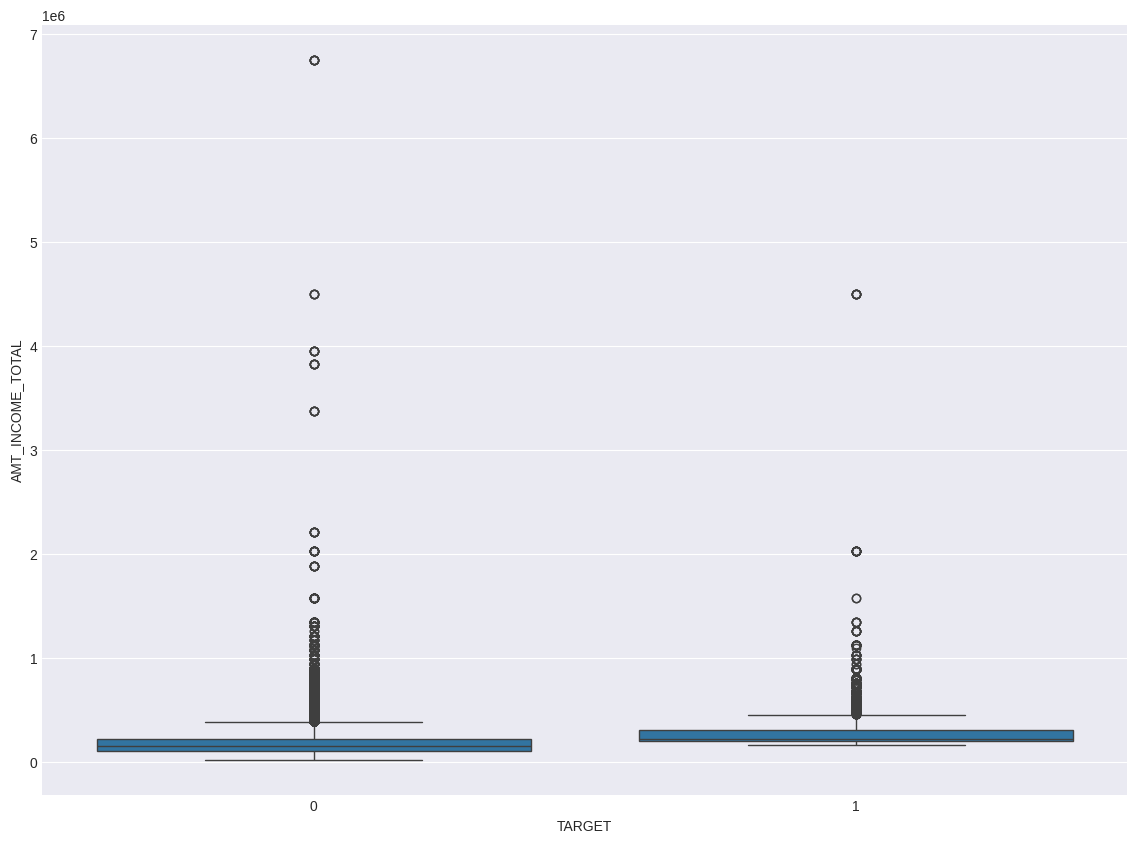

In [ ]:
sns.boxplot(x=dataset["TARGET"], y=dataset["AMT_INCOME_TOTAL"], data=dataset);

La variabile "DAYS_BIRTH" considerata in questo contesto come una variabile continua, è molto informativa.

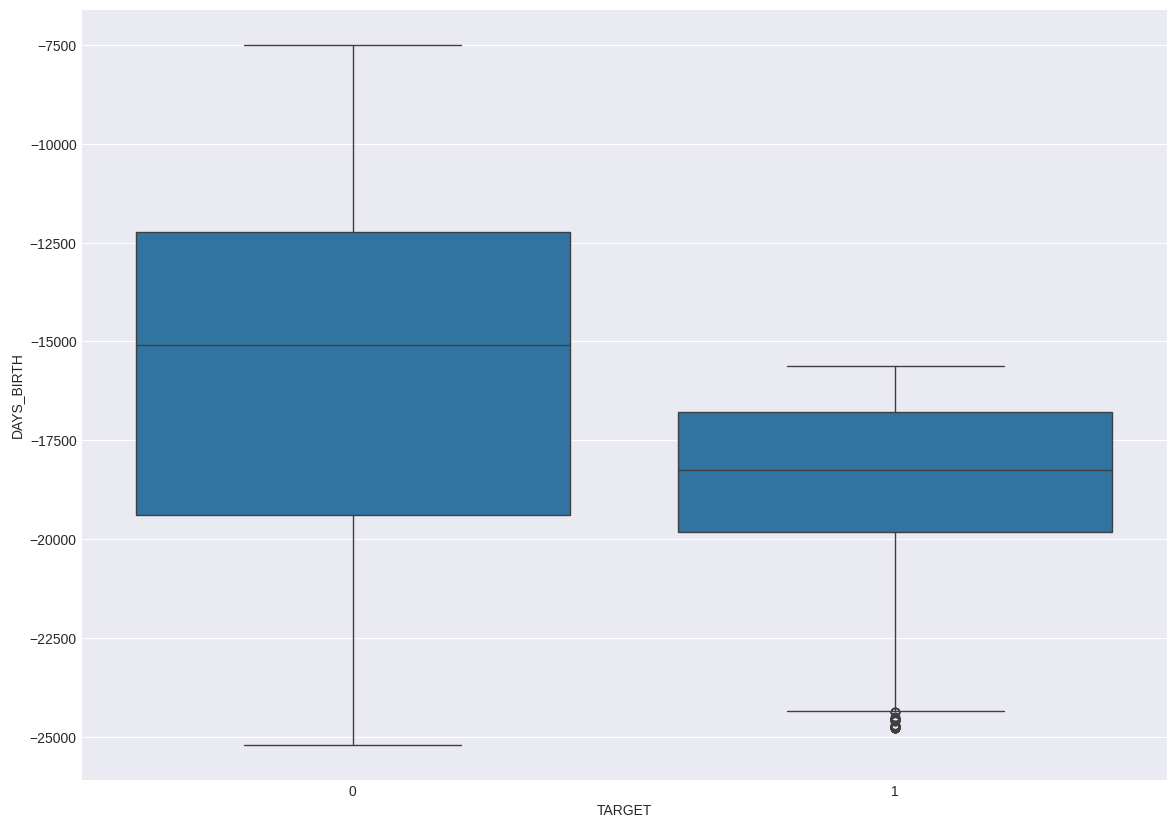

In [ ]:
sns.boxplot(x=dataset["TARGET"], y=dataset["DAYS_BIRTH"], data=dataset);

Utilizzo del test statistico Chi X per verificare l'indipendenza tra variabili.

In [ ]:
X = dataset["CODE_GENDER"]
y = dataset["TARGET"]

chi2(X, y)

Chi2: 75.07
P-value: 0.00
Gradi di Libertà: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["FLAG_OWN_CAR"]

chi2(X, y)

Chi2: 401.52
P-value: 0.00
Gradi di Libertà: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["FLAG_OWN_REALTY"]

chi2(X, y)

Chi2: 306.31
P-value: 0.00
Gradi di Libertà: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["CNT_CHILDREN"]

chi2(X, y)

Chi2: 3170.74
P-value: 0.00
Gradi di Libertà: 11
Le variabili sono dipendenti.


In [ ]:
X = dataset["NAME_INCOME_TYPE"]

chi2(X, y)

Chi2: 7456.89
P-value: 0.00
Gradi di Libertà: 3
Le variabili sono dipendenti.


In [ ]:
X = dataset["NAME_EDUCATION_TYPE"]

chi2(X, y)

Chi2: 566.15
P-value: 0.00
Gradi di Libertà: 4
Le variabili sono dipendenti.


In [ ]:
X = dataset["NAME_FAMILY_STATUS"]

chi2(X, y)

Chi2: 444.75
P-value: 0.00
Gradi di Libertà: 3
Le variabili sono dipendenti.


In [ ]:
X = dataset["NAME_HOUSING_TYPE"]

chi2(X, y)

Chi2: 831.95
P-value: 0.00
Gradi di Libertà: 1
Le variabili sono dipendenti.


In [ ]:
X = dataset["OCCUPATION_TYPE"]

chi2(X, y)

Chi2: 3670.90
P-value: 0.00
Gradi di Libertà: 2
Le variabili sono dipendenti.


In [ ]:
X = dataset["CNT_FAM_MEMBERS"]

chi2(X, y)

Chi2: 2886.57
P-value: 0.00
Gradi di Libertà: 12
Le variabili sono dipendenti.


**Analisi multivariata.**

Utilizzo del coefficiente di correlazione di Spearman, valido per variabili ordinabili e variabili a intervalli.

<Axes: >

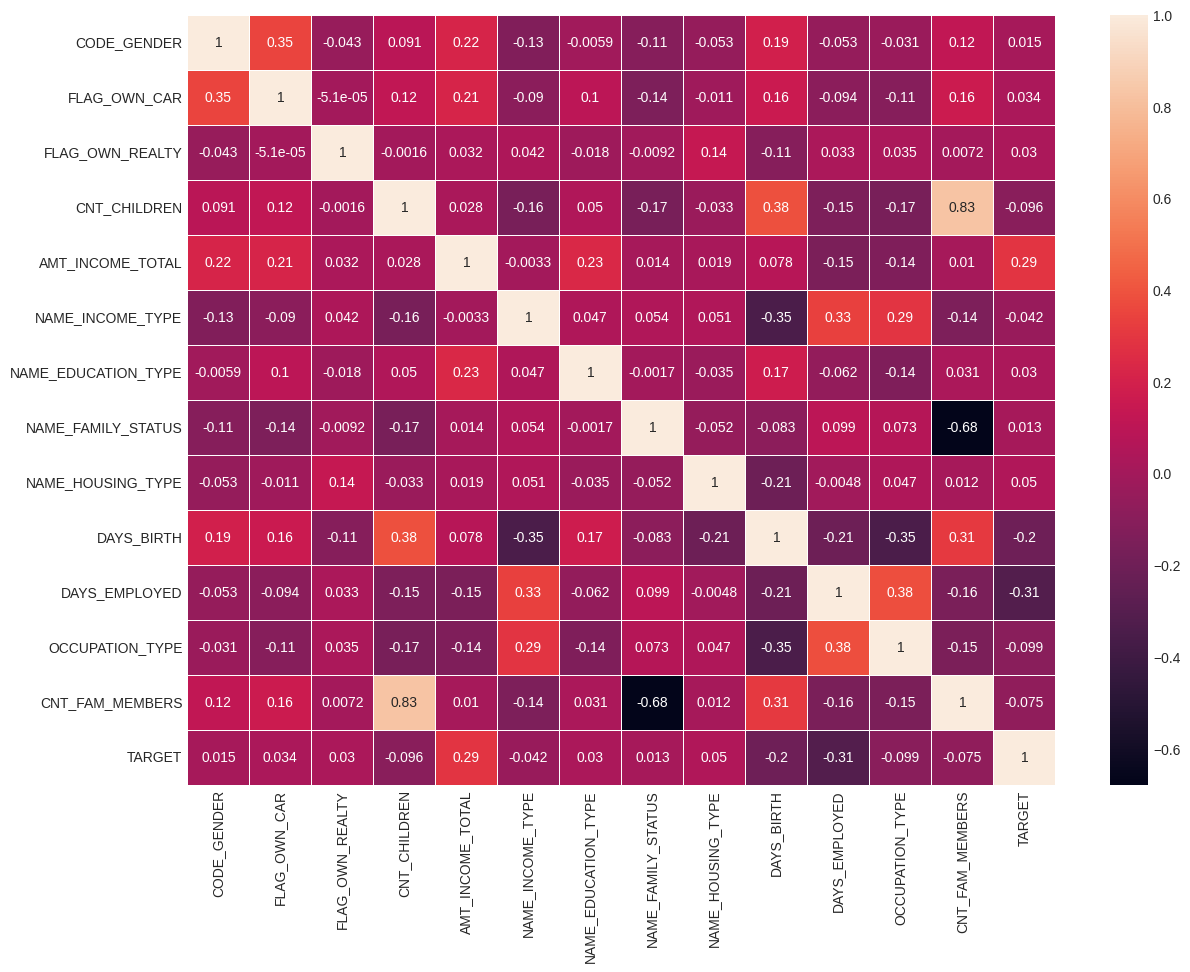

In [ ]:
corr_spearman = dataset.corr(method="spearman")
sns.heatmap(corr_spearman, annot=True, linewidths=.5)

In [ ]:
dataset[["CNT_FAM_MEMBERS", "CNT_CHILDREN"]].corr(method="spearman")

,CNT_FAM_MEMBERS,CNT_CHILDREN
CNT_FAM_MEMBERS,1.000000,0.827607
CNT_CHILDREN,0.827607,1.000000


In [ ]:
dataset = dataset.drop(["CNT_FAM_MEMBERS"], axis=1)


Verifica del bilanciamento della variabile target, un pesante sbilanciamento può compromettere la stabilità del modello.

In [ ]:
counts = dataset["TARGET"].value_counts()

print(f"Bassa affidabilità creditizia = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%) ")
print(f"Elevata affidabilità creditizia = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%) ")

Bassa affidabilità creditizia = 308690 (91.22%) 
Elevata affidabilità creditizia = 29719 (8.78%) 


In [ ]:
X = dataset.drop("TARGET", axis=1).values
y = dataset["TARGET"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (236886, 12)
X_test: (101523, 12)


Utilizzo del OneHotEncoder per le features precedentemente descritte.

In [ ]:
c_transf = ColumnTransformer([("ohe", OneHotEncoder(), [5, 7, 11])], remainder="passthrough")
X_train = c_transf.fit_transform(X_train)
X_test = c_transf.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (236886, 20)
X_test: (101523, 20)


In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

**Addestramento del modello di classificazione.**

Modello baseline: regressione logistica.

Il bilanciamento delle classi inizialmente viene gestito dall'iperparametro "class_weight".

In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

evaluate(lr, X_train, X_test, y_train, y_test)

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.99      0.82      0.89    216087
           1       0.32      0.89      0.47     20799

    accuracy                           0.82    236886
   macro avg       0.65      0.85      0.68    236886
weighted avg       0.93      0.82      0.86    236886

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     92603
           1       0.32      0.88      0.47      8920

    accuracy                           0.82    101523
   macro avg       0.65      0.85      0.68    101523
weighted avg       0.93      0.82      0.86    101523

-----------------------------------------------------


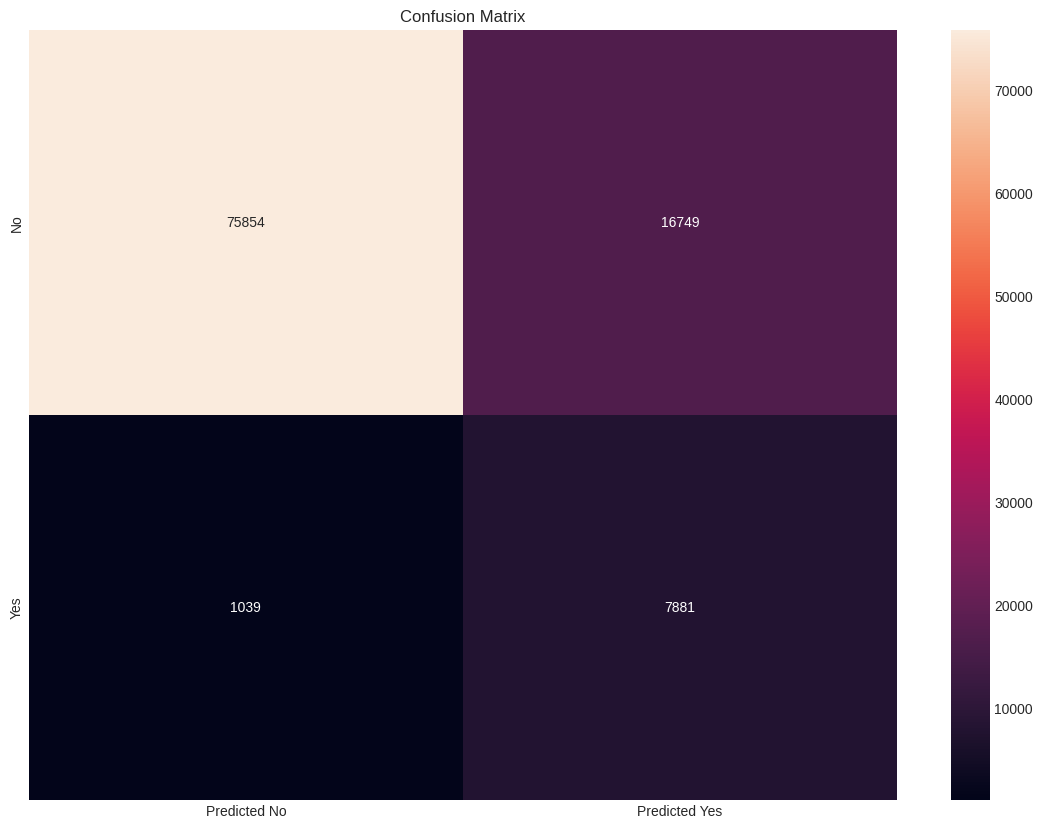

In [ ]:
plot_confusion_matrix(y_test, lr.predict(X_test), ["No", "Yes"])

Addestramento del modello con bilanciamento ROS per la creazione di features sintetiche del target meno presente.

Le metriche migliorano di 0.01 ma il modello mostra una condizione di overfitting per la classe target=1.

In [ ]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (432174, 20)
X_test: (101523, 20)


In [ ]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train, y_train)

evaluate(lr, X_train, X_test, y_train, y_test)

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.82      0.85    216087
           1       0.83      0.88      0.86    216087

    accuracy                           0.85    432174
   macro avg       0.85      0.85      0.85    432174
weighted avg       0.85      0.85      0.85    432174

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     92603
           1       0.32      0.88      0.47      8920

    accuracy                           0.82    101523
   macro avg       0.65      0.85      0.68    101523
weighted avg       0.93      0.82      0.86    101523

-----------------------------------------------------


Regolarizzazione per gestire l'overfitting attraverso la ricerca dell'iperparametro migliore per bilanciare tra L1 e L2.

Nessun miglioramento valido per le metriche e il modello continua a mostrare una condizione di overfitting.

In [ ]:
for ratio in [0.2, 0.4, 0.6, 0.8, 1]:
  lr = LogisticRegression(penalty="elasticnet", class_weight="balanced", solver="saga", l1_ratio=ratio)
  lr.fit(X_train, y_train)

  print(f"-------------FIT CON RATIO: {ratio}---------------")
  evaluate(lr, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-------------FIT CON RATIO: 0.2---------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.81      0.84    216087
           1       0.83      0.89      0.86    216087

    accuracy                           0.85    432174
   macro avg       0.85      0.85      0.85    432174
weighted avg       0.85      0.85      0.85    432174

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     92603
           1       0.31      0.89      0.46      8920

    accuracy                           0.82    101523
   macro avg       0.65      0.85      0.68    101523
weighted avg       0.93      0.82      0.85    101523

-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-------------FIT CON RATIO: 0.4---------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.81      0.84    216087
           1       0.83      0.89      0.86    216087

    accuracy                           0.85    432174
   macro avg       0.85      0.85      0.85    432174
weighted avg       0.85      0.85      0.85    432174

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     92603
           1       0.31      0.89      0.46      8920

    accuracy                           0.82    101523
   macro avg       0.65      0.85      0.68    101523
weighted avg       0.93      0.82      0.85    101523

-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-------------FIT CON RATIO: 0.6---------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.81      0.84    216087
           1       0.83      0.89      0.86    216087

    accuracy                           0.85    432174
   macro avg       0.85      0.85      0.85    432174
weighted avg       0.85      0.85      0.85    432174

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     92603
           1       0.31      0.89      0.46      8920

    accuracy                           0.82    101523
   macro avg       0.65      0.85      0.68    101523
weighted avg       0.93      0.82      0.85    101523

-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-------------FIT CON RATIO: 0.8---------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.81      0.84    216087
           1       0.83      0.89      0.86    216087

    accuracy                           0.85    432174
   macro avg       0.85      0.85      0.85    432174
weighted avg       0.85      0.85      0.85    432174

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     92603
           1       0.31      0.89      0.46      8920

    accuracy                           0.82    101523
   macro avg       0.65      0.85      0.68    101523
weighted avg       0.93      0.82      0.85    101523

-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


-------------FIT CON RATIO: 1---------------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.88      0.81      0.84    216087
           1       0.83      0.89      0.86    216087

    accuracy                           0.85    432174
   macro avg       0.85      0.85      0.85    432174
weighted avg       0.85      0.85      0.85    432174

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     92603
           1       0.31      0.89      0.46      8920

    accuracy                           0.82    101523
   macro avg       0.65      0.85      0.68    101523
weighted avg       0.93      0.82      0.85    101523

-----------------------------------------------------


Verifica parametrica per considerare l'addestramento di modelli che non fanno assunzioni sulla distribuzione dei dati.

La media e la mediana (probabilmente anche la moda) non sono equivalenti.

In [ ]:
dataset.median()

CODE_GENDER                 0.0
FLAG_OWN_CAR                0.0
FLAG_OWN_REALTY             1.0
CNT_CHILDREN                0.0
AMT_INCOME_TOTAL       162000.0
NAME_INCOME_TYPE            0.0
NAME_EDUCATION_TYPE         1.0
NAME_FAMILY_STATUS          4.0
NAME_HOUSING_TYPE           1.0
DAYS_BIRTH             -15622.0
DAYS_EMPLOYED           -1485.0
OCCUPATION_TYPE             8.0
TARGET                      0.0
dtype: float64

In [ ]:
dataset.mean()

CODE_GENDER                 0.326543
FLAG_OWN_CAR                0.370052
FLAG_OWN_REALTY             0.683475
CNT_CHILDREN                0.428942
AMT_INCOME_TOTAL       187656.104281
NAME_INCOME_TYPE            0.821819
NAME_EDUCATION_TYPE         1.564424
NAME_FAMILY_STATUS          4.382425
NAME_HOUSING_TYPE           0.956792
DAYS_BIRTH             -15998.321182
DAYS_EMPLOYED           60241.647214
OCCUPATION_TYPE             8.793504
TARGET                      0.087820
dtype: float64

Verifica grafica della distribuzione dei dati.

Il grafico conferma che i dati non si distribuiscono seguendo la normale.

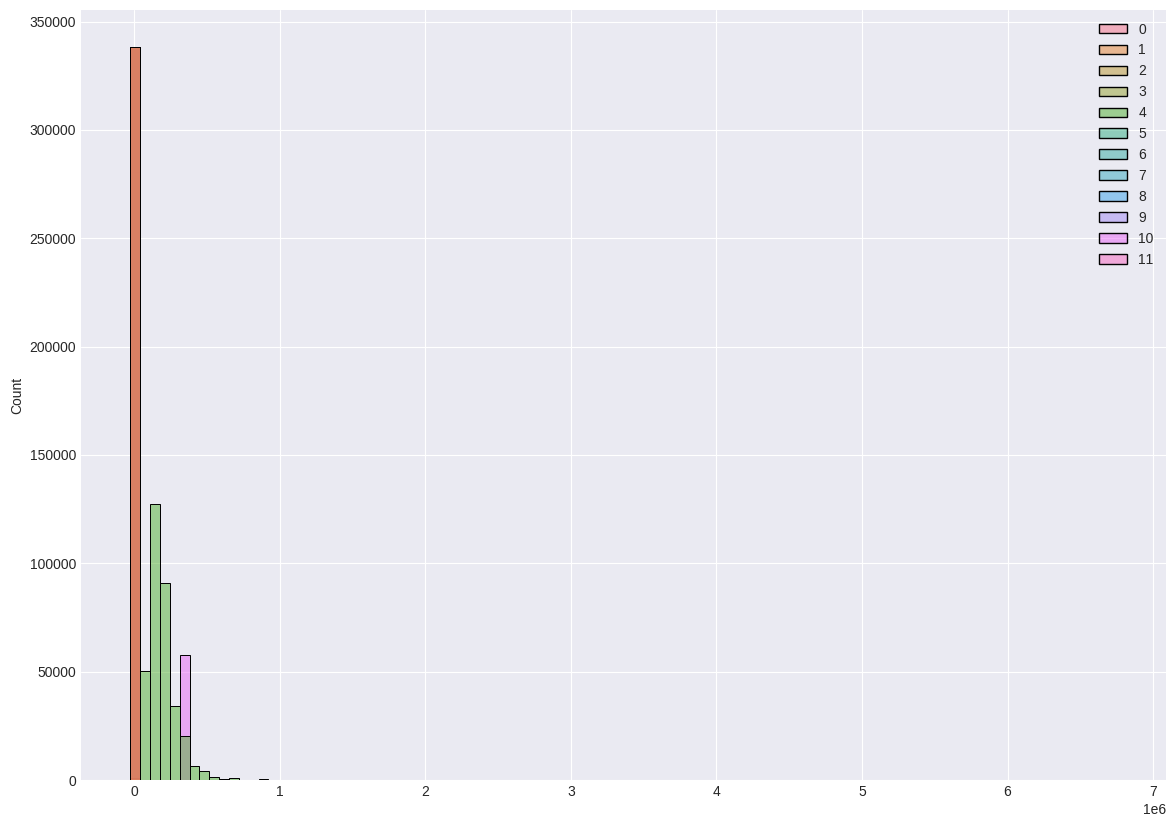

In [ ]:
sns.histplot(X, bins=100);

**Addestramento di modelli non parametrici.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

c_transf = ColumnTransformer([("ohe", OneHotEncoder(), [5, 7, 11])], remainder="passthrough")
X_train = c_transf.fit_transform(X_train)
X_test = c_transf.transform(X_test)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

*K-Nearest Neighbors (KNN).*

Ottimizzazione dell'iperparametro per il modello di classificazione K-NN.

Il modello soffrirà per la presenza di outlier, ma risulta facile da interpretare.

In [ ]:
for neighbors in range(3, 7):
  knn = KNeighborsClassifier(n_neighbors=neighbors)
  knn.fit(X_train, y_train)

  print(f"-----------FIT CON N_NEIGHBORS: {neighbors}----------")
  evaluate(knn, X_train, X_test, y_train, y_test)

-----------FIT CON N_NEIGHBORS: 3----------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    216254
           1       0.76      0.83      0.79     20632

    accuracy                           0.96    236886
   macro avg       0.87      0.90      0.89    236886
weighted avg       0.96      0.96      0.96    236886

TEST REPORT
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     92436
           1       0.68      0.72      0.70      9087

    accuracy                           0.94    101523
   macro avg       0.82      0.84      0.83    101523
weighted avg       0.95      0.94      0.94    101523

-----------------------------------------------------
-----------FIT CON N_NEIGHBORS: 4----------
TRAIN REPORT
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    216254
           1       0.79      0.69      0.74     20632

  

Addestramento del modello con il miglior valore di K e la "regolarizzazione" con la pesatura delle distanze gestito dall'iperparametro "weights".

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, weights="distance")
knn.fit(X_train, y_train)

evaluate(knn, X_train, X_test, y_train, y_test)

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    216254
           1       0.78      0.84      0.81     20632

    accuracy                           0.97    236886
   macro avg       0.88      0.91      0.90    236886
weighted avg       0.97      0.97      0.97    236886

TEST REPORT
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     92436
           1       0.69      0.72      0.71      9087

    accuracy                           0.95    101523
   macro avg       0.83      0.85      0.84    101523
weighted avg       0.95      0.95      0.95    101523

-----------------------------------------------------


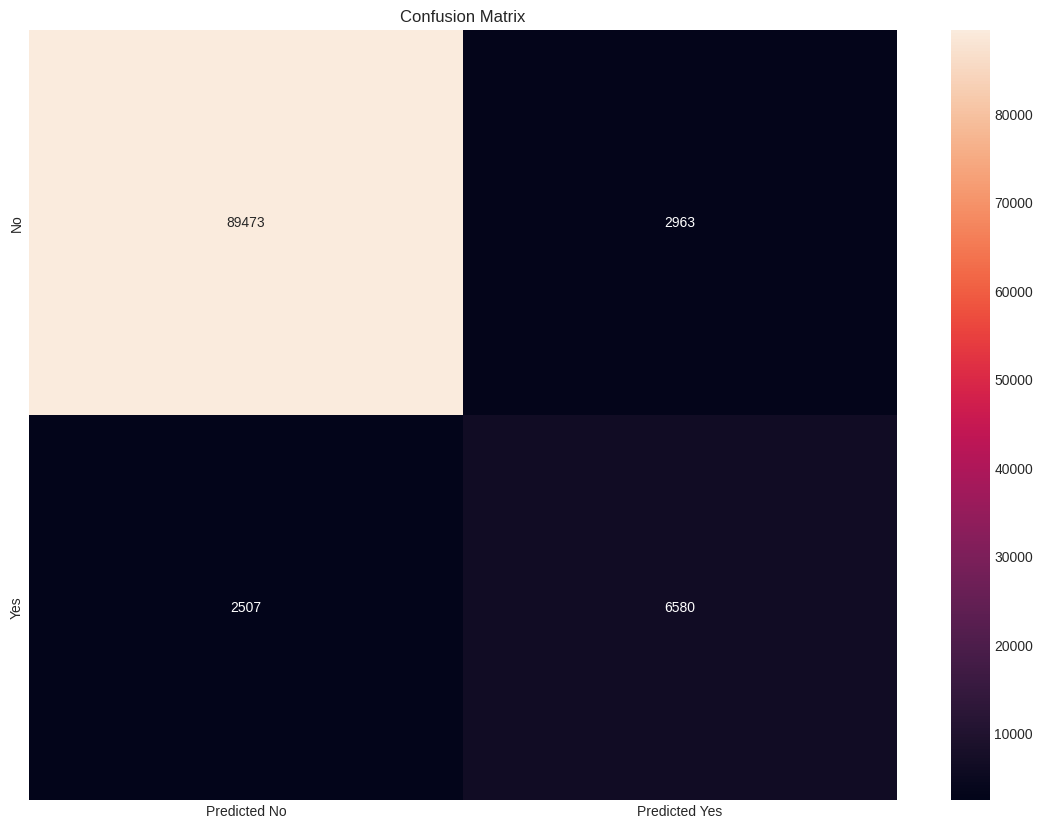

In [ ]:
plot_confusion_matrix(y_test, knn.predict(X_test), ["No", "Yes"])

*Support Vector Machines (SVM).*

Il modello non dovrebbe soffrire per la presenza di outlier, ma risulta difficile da interpretare.

In [ ]:
svc = SVC(kernel="sigmoid")
svc.fit(X_train, y_train)

evaluate(svc, X_train, X_test, y_train, y_test)

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    216206
           1       0.19      0.19      0.19     20680

    accuracy                           0.86    236886
   macro avg       0.56      0.56      0.56    236886
weighted avg       0.86      0.86      0.86    236886

TEST REPORT
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     92484
           1       0.19      0.19      0.19      9039

    accuracy                           0.86    101523
   macro avg       0.56      0.56      0.56    101523
weighted avg       0.86      0.86      0.86    101523

-----------------------------------------------------


Addestramento del modello con differente kernel.

In [ ]:
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)

evaluate(svc, X_train, X_test, y_train, y_test)

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    216152
           1       0.64      0.19      0.29     20734

    accuracy                           0.92    236886
   macro avg       0.78      0.59      0.62    236886
weighted avg       0.90      0.92      0.90    236886

TEST REPORT
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     92538
           1       0.61      0.18      0.28      8985

    accuracy                           0.92    101523
   macro avg       0.77      0.59      0.62    101523
weighted avg       0.90      0.92      0.90    101523

-----------------------------------------------------


Conclusione:

Considerando che l'obbiettivo dell'addestramento del modello di classificazione consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia di un clienti, al fine di di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.

Considerando i modelli addestrati fino ad ora senza ulteriori ottimizzazioni, il modello migliore è il modello K-Nearest Neighbors (KNN) perché nonstante la presenza di un "leggero" overfitting per la classe sottocampionata (target=1), è il modello che mantiene le metriche più equilibrate.

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    216173
           1       0.78      0.84      0.81     20713

    accuracy                           0.97    236886

TEST REPORT
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     92517
           1       0.69      0.73      0.71      9006

    accuracy                           0.95    101523